# **Imports**

In [75]:
import pandas as pd
import spacy
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
df = pd.read_csv('/content/tweets.csv')

# **EDA**

In [81]:
df.head()

print("Most of the features can be cleaned up, only 'tweets' and 'class' is required")
print("\nMeanings of the classes in the output label\n\n{0 : 'hate', 1 : 'offensive', 2 : 'neither'}")

Most of the features can be cleaned up, only 'tweets' and 'class' is required

Meanings of the classes in the output label

{0 : 'hate', 1 : 'offensive', 2 : 'neither'}


In [82]:
# Deleting the unwanted columns
df.drop(columns = ['Unnamed: 0',	'count',	'hate_speech',	'offensive_language',	'neither'],
        inplace = True)

In [86]:
df.info()

print("\nClass is an int and tweet is an object")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB

Class is an int and tweet is an object


In [88]:
# Checking for null values
print(df.isna().sum())

print("\nNo null values")

class    0
tweet    0
dtype: int64

No null values


In [36]:
# Taking a better look at the data
for i in range (5):
  print(df['tweet'].iloc[i])

print("\nThere are unnecessary symbols and numbers that can be removed")

!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
!!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you hear about me might be true or it might be faker than the bitch who told it to ya &#57361;

There are unnecessary symbols and numbers that can be removed


# **Preprocessing**

In [37]:
# Removing unnecessary symbols and numbers
df['tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex = True)

In [38]:
for i in range (5):
  print(df['tweet'].iloc[i])

print("\nThere is still multiple spacing in between words")

    RT  mayasolovely  As a woman you shouldn t complain about cleaning up your house   amp  as a man you should always take the trash out   
      RT  mleew    boy dats cold   tyga dwn bad for cuffin dat hoe in the  st place  
        RT  UrKindOfBrand Dawg     RT    sbaby life  You ever fuck a bitch and she start to cry  You be confused as shit
          RT  C G Anderson   viva based she look like a tranny
              RT  ShenikaRoberts  The shit you hear about me might be true or it might be faker than the bitch who told it to ya         

There is still too much spacing in between words


In [39]:
# Replacing multiple whitespaces with just one space
df['tweet'] = df['tweet'].str.replace(r'[\s]+', ' ', regex = True)

In [40]:
df.head()

,class,tweet,processed_tweet,processed_tweet_2
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...,RT mayasolovely As a woman you shouldn t comp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...,RT C G Anderson viva based she look like a tr...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...,RT ShenikaRoberts The shit you hear about me ...


In [41]:
print("After removing extra spacing\n")
for i in range (5):
  print(df['tweet'].iloc[i])

 RT mayasolovely As a woman you shouldn t complain about cleaning up your house amp as a man you should always take the trash out 
 RT mleew boy dats cold tyga dwn bad for cuffin dat hoe in the st place 
 RT UrKindOfBrand Dawg RT sbaby life You ever fuck a bitch and she start to cry You be confused as shit
 RT C G Anderson viva based she look like a tranny
 RT ShenikaRoberts The shit you hear about me might be true or it might be faker than the bitch who told it to ya 

Better


In [44]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [47]:
# Load out spacy's english web small model
nlp = spacy.load('en_core_web_sm')

In [48]:
# Lemmatizing the words to their base words
def lemmatization(text):
  doc = nlp(text)
  lemmaList = [word.lemma_ for word in doc]
  return ' '.join(lemmaList)

df['lemma_tweet'] = df['tweet'].apply(lemmatization)

In [49]:
print("After lematizing each word\n")
for i in range (5):
  print(df['lemma_tweet'].iloc[i])

  RT mayasolovely as a woman you shouldn t complain about clean up your house amp as a man you should always take the trash out
  RT mleew boy dat cold tyga dwn bad for cuffin dat hoe in the st place
  RT UrKindOfBrand Dawg RT sbaby life you ever fuck a bitch and she start to cry you be confuse as shit
  RT C G Anderson viva base she look like a tranny
  RT ShenikaRoberts the shit you hear about I might be true or it might be faker than the bitch who tell it to ya

Better


In [50]:
# Removing stop words
def remove_stopwords(text):
  doc = nlp(text)
  no_stopwords_list = [word.text for word in doc if not word.is_stop]
  return ' '.join(no_stopwords_list)

df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

In [51]:
df.head()

,class,processed_tweet_2,lemma_tweet,final_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...,RT mayasolovely woman shouldn t complain cl...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad cuffin d...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...,RT UrKindOfBrand Dawg RT sbaby life fuck bi...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...,RT C G Anderson viva base look like tranny
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...,RT ShenikaRoberts shit hear true faker bitc...


In [52]:
print("After removing stop words\n")

for i in range (5):
  print(df['final_tweet'].iloc[i])

   RT mayasolovely woman shouldn t complain clean house amp man trash
   RT mleew boy dat cold tyga dwn bad cuffin dat hoe st place
   RT UrKindOfBrand Dawg RT sbaby life fuck bitch start cry confuse shit
   RT C G Anderson viva base look like tranny
   RT ShenikaRoberts shit hear true faker bitch tell ya

Better


In [53]:
# One hot representation
vocab_size = 10000
one_hot_representation = [one_hot(words, vocab_size) for words in df['final_tweet']]

In [54]:
# Comparing original tweet and after one hot encoding
print(df['final_tweet'].iloc[0])
print(one_hot_representation[0])

   RT mayasolovely woman shouldn t complain clean house amp man trash
[151, 3621, 1913, 8828, 4551, 7310, 6151, 8892, 4709, 8708, 6322]


In [55]:
# Adding paddnig to make the sentences the same length
sentence_length = 20
embedded_tweet = pad_sequences(one_hot_representation, padding='pre', maxlen = sentence_length)

In [56]:
embedded_tweet[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  151, 3621,
       1913, 8828, 4551, 7310, 6151, 8892, 4709, 8708, 6322], dtype=int32)

In [59]:
# Splitting the label and the features
X = np.array(embedded_tweet)
y = np.array(df['class'])

In [60]:
# Smoting the fix the class imbalance
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

In [61]:
# Splitting to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# **LSTM Model**

In [62]:
# Model architecture

dimension = 50

model = keras.Sequential([
    #embedding layer
    keras.layers.Embedding(vocab_size, dimension, input_length = sentence_length),
    # LSTM layer
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    #output layer
    keras.layers.Dense(3, activation = 'softmax')
])

#compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [63]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Training the model
model.fit(X_train, y_train, epochs = 10, batch_size=32)

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.7779 - loss: 0.5087
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.9460 - loss: 0.1675
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.9631 - loss: 0.1185
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.9717 - loss: 0.0930
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 44ms/step - accuracy: 0.9794 - loss: 0.0708
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.9823 - loss: 0.0571
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.9884 - loss: 0.0388
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.9912 - loss: 0.0260
Epoch 9/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 83s 46ms/step - accuracy: 0.9930 - loss: 0.0209
Epoch 10/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.9955 - loss: 0.0148


In [73]:
# Evaluating model accuracy
loss, accuracy = model.evaluate(X_test, y_test)
pred = np.argmax(model.predict(X_test), axis = -1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8996 - loss: 0.5973
266/266 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


In [74]:
# Printing classification report
print("Classification Report: \n")
print(f'Model Accuracy : {accuracy * 100}\n')
print(classification_report(y_test, pred))

Classification Report: 

Model Accuracy : 89.57574367523193

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3812
           1       0.92      0.91      0.91      3807
           2       0.75      0.71      0.73       890

    accuracy                           0.90      8509
   macro avg       0.86      0.85      0.85      8509
weighted avg       0.89      0.90      0.90      8509



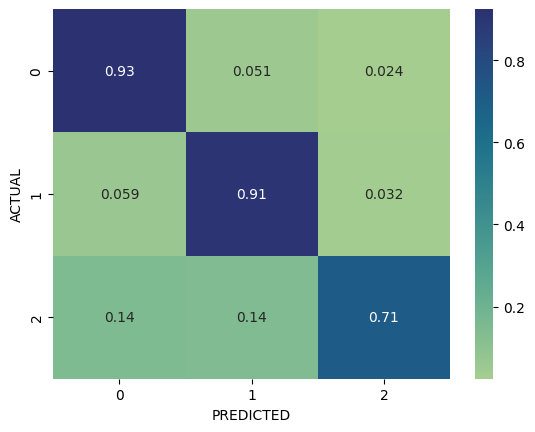

In [68]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest')
plt.xlabel('PREDICTED'),
plt.ylabel('ACTUAL');